
# Property Price Estimation

This is a simple model to estimate house prices.

I have implemented and autotuned 4 difffrent regressor ensemble models : Random Forest, XGBoost, CatBoost and LGBM.

After finding the best hyperparameters for the 4 enemble models, I have implemented Stacking Regressor to combine the results.

This data has 110 different features. However, as many of the features have almost no relation to the proprty price, I have excluded many of them.

In [145]:
import time                      # Import libraries
start_time = time.time()

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
import plotly.express as px
import seaborn as sns
from tqdm.notebook import trange

from sklearn.preprocessing import StandardScaler      # Import sklearn libraries
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor

from xgboost import XGBRegressor                     # Import few powerful Regressor Libraries
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor



In [134]:
loading_a_pickle_file = pickle.load(open("./DATA/house_df.pkl", "rb"))
loading_a_pickle_file.head()

df = shuffle(loading_a_pickle_file)


In [135]:
features_list = df.columns.values.tolist()  # Create a list for the name of all the features
print("List size before moving the label: ",len(features_list))     # Size of the column's list
features_list.remove('SalePriceLog')    # Deleting an entity of the list which is the label(not feature)
print("List size after moving the label: ",len(features_list))     # Size of the column's list

List size before moving the label:  110
List size after moving the label:  109


In [136]:
df.isnull().sum().sum()   # Check if there is any Nan in the dataframe

0

In [24]:
df.duplicated().sum()    # Check for duplication

0

In [25]:
#Splitting train and test sets
house_train, house_test = train_test_split(df, test_size=0.25, random_state=42)
print(house_train.shape)
print(house_test.shape)

(1042, 110)
(348, 110)


In [26]:
#Splitting train and validation sets
house_train, house_val = train_test_split(house_train, test_size=0.25, random_state=42)
print(house_train.shape)
print(house_val.shape)

(781, 110)
(261, 110)


In [27]:
df.describe() # check the description of all the numeric features(which are all the features)

,TotalBsmtSFSqrt,OpenPorchSFLog,MasVnrAreaSqrt,YearRemodAdd,FirstFlrSFLog,GrLivAreaLog,LotAreaSqrt,YearBuilt,SalePriceLog,KitchenQual_Ex,...,MSZoning_RH,MSZoning_RL,MSZoning_RM,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,...,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000
mean,31.387210,-4.029443,6.019169,1985.015827,6.998242,7.258338,95.906207,1971.672662,12.021953,0.064748,...,0.011511,0.789928,0.150360,0.058273,0.021583,0.920144,0.478417,0.450360,0.068345,0.002878
std,7.535796,8.967297,8.075006,20.555876,0.309415,0.324334,20.186159,29.942422,0.377492,0.246170,...,0.106707,0.407506,0.357552,0.234344,0.145369,0.271168,0.499714,0.497709,0.252428,0.053586
min,0.000000,-13.815511,0.000000,1950.000000,5.811141,5.811141,36.055513,1872.000000,10.471950,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.178006,-13.815511,0.000000,1967.000000,6.777076,7.025538,86.481183,1954.000000,11.775290,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,31.344855,3.178054,0.000000,1994.000000,6.982399,7.283448,96.757428,1973.000000,11.996892,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,35.619517,4.189655,12.806248,2004.000000,7.221105,7.476189,106.591510,2000.750000,12.264342,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,56.621551,5.897154,40.000000,2010.000000,8.079618,8.158516,186.145105,2010.000000,13.275828,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
#Function to split features from Label
def split_features_labels(dataframe_name,label):
    Y_ = dataframe_name[[label]]
    X_ = dataframe_name.drop([label], axis=1)
    return(X_,Y_)

In [29]:
# Separating the features from the Sale Price
X_train, Y_train = split_features_labels(house_train,"SalePriceLog")
X_val, Y_val = split_features_labels(house_val,"SalePriceLog")
X_test, Y_test = split_features_labels(house_test,"SalePriceLog")


In [30]:
# Resetting the indecies of training, validation and test sets

X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)

X_val.reset_index(drop=True, inplace=True)
Y_val.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

In [31]:
scalar = StandardScaler()   # Standardising all the numerical features in traning dataframe
X_train = scalar.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = features_list

Y_train = pd.DataFrame(Y_train)
Y_train.columns = ["SalePriceLog"]

df_train = pd.DataFrame(X_train, copy = True)  # Creating a training dataframe with all the features and label
df_train["SalePriceLog"]=Y_train

In [32]:
 #  Standardising all the numerical features in validation dataframe
X_val = scalar.fit_transform(X_val)
X_val = pd.DataFrame(X_val)
X_val.columns = features_list

Y_val = pd.DataFrame(Y_val)
Y_val.columns = ["SalePriceLog"]

In [33]:
 #  Standardising all the numerical features in test dataframe
X_test = scalar.fit_transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = features_list

Y_test = pd.DataFrame(Y_test)
Y_test.columns = ["SalePriceLog"]

In [34]:
# Getting rid of all the columns with low correlation with the label

corr_matrix = df_train.corr()
for i in range(len(corr_matrix)-1):
    if np.abs(corr_matrix.iloc[i]["SalePriceLog"]) < 0.3:
        df_train.drop([features_list[i]], axis=1, inplace = True)
        X_train.drop([features_list[i]], axis=1, inplace = True)
        X_val.drop([features_list[i]], axis=1, inplace = True)
        X_test.drop([features_list[i]], axis=1, inplace = True)
       
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TotalBsmtSFSqrt       781 non-null    float64
 1   OpenPorchSFLog        781 non-null    float64
 2   MasVnrAreaSqrt        781 non-null    float64
 3   YearRemodAdd          781 non-null    float64
 4   FirstFlrSFLog         781 non-null    float64
 5   GrLivAreaLog          781 non-null    float64
 6   LotAreaSqrt           781 non-null    float64
 7   YearBuilt             781 non-null    float64
 8   KitchenQual_Ex        781 non-null    float64
 9   KitchenQual_Gd        781 non-null    float64
 10  KitchenQual_TA        781 non-null    float64
 11  OverallQual_4         781 non-null    float64
 12  OverallQual_5         781 non-null    float64
 13  OverallQual_8         781 non-null    float64
 14  OverallQual_9         781 non-null    float64
 15  Neighborhood_NridgHt  7

## Random Forest Regressor

In [35]:
#Predicting using RandomForest
lowest_error_rf = np.inf
for max_depth in trange(4,15,1):
    randomforestregressor = RandomForestRegressor(n_estimators = 100, max_features = 2,max_depth = max_depth)
    randomforestregressor.fit(X_train, Y_train)
    Y_prediction = randomforestregressor.predict(X_val)
    Y_val["SalePricePred"] = Y_prediction
    current_error = mean_absolute_error(Y_val["SalePriceLog"], Y_val["SalePricePred"])
    if current_error < lowest_error_rf:
        lowest_error_rf = current_error
        best_max_depth_rf = max_depth
print("\n best_max_depth =",best_max_depth_rf," lowest_error=", round(lowest_error_rf*100,2),"%")


C:\Users\AICORE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\AICORE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\AICORE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\AICORE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\AICORE\AppData\



 best_max_depth = 11  lowest_error= 9.08 %


## XGBoost Regressor

In [36]:
#Predicting using XGBoost
lowest_error_xgb = np.inf
for max_depth in trange(4,15,1):
    xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth = max_depth)
    xgb_regressor.fit(X_train, Y_train)
    Y_prediction = xgb_regressor.predict(X_val)
    Y_val["SalePricePred"] = Y_prediction
    current_error = mean_absolute_error(Y_val["SalePriceLog"], Y_val["SalePricePred"])
    if current_error < lowest_error_xgb:
        lowest_error_xgb = current_error
        best_max_depth_xgb = max_depth
print("\n best_max_depth =",best_max_depth_xgb," lowest_error=", round(lowest_error_xgb*100,2),"%")



 best_max_depth = 6  lowest_error= 8.98 %


## CatBoost Regressor

In [37]:
#Predicting using CatBoost
lowest_error_cat = np.inf
for max_depth in trange(4,15,1):
    cat_regressor = CatBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth = max_depth)
    cat_regressor.fit(X_train, Y_train)
    Y_prediction = cat_regressor.predict(X_val)
    Y_val["SalePricePred"] = Y_prediction
    current_error = mean_absolute_error(Y_val["SalePriceLog"], Y_val["SalePricePred"])
    if current_error < lowest_error_cat:
        lowest_error_cat = current_error
        best_max_depth_cat = max_depth
print("\n best_max_depth =",best_max_depth_cat," lowest_error=", round(lowest_error_cat*100,2),"%")

0:	learn: 0.3536207	total: 21.1ms	remaining: 2.09s
1:	learn: 0.3338265	total: 23.9ms	remaining: 1.17s
2:	learn: 0.3144372	total: 26.3ms	remaining: 852ms
3:	learn: 0.2982915	total: 28.5ms	remaining: 685ms
4:	learn: 0.2823465	total: 30.5ms	remaining: 580ms
5:	learn: 0.2686828	total: 32.2ms	remaining: 505ms
6:	learn: 0.2576658	total: 34.5ms	remaining: 458ms
7:	learn: 0.2446763	total: 36ms	remaining: 414ms
8:	learn: 0.2340053	total: 37.6ms	remaining: 380ms
9:	learn: 0.2246109	total: 39.1ms	remaining: 352ms
10:	learn: 0.2162072	total: 40.5ms	remaining: 328ms
11:	learn: 0.2085545	total: 42ms	remaining: 308ms
12:	learn: 0.2013532	total: 43.4ms	remaining: 290ms
13:	learn: 0.1943588	total: 44.8ms	remaining: 275ms
14:	learn: 0.1887927	total: 46.2ms	remaining: 262ms
15:	learn: 0.1829814	total: 47.6ms	remaining: 250ms
16:	learn: 0.1786462	total: 49ms	remaining: 239ms
17:	learn: 0.1747008	total: 62.7ms	remaining: 286ms
18:	learn: 0.1710012	total: 67ms	remaining: 286ms
19:	learn: 0.1666563	total: 70

96:	learn: 0.0980037	total: 335ms	remaining: 10.4ms
97:	learn: 0.0975502	total: 338ms	remaining: 6.9ms
98:	learn: 0.0972515	total: 341ms	remaining: 3.45ms
99:	learn: 0.0969879	total: 344ms	remaining: 0us
0:	learn: 0.3526477	total: 10.7ms	remaining: 1.05s
1:	learn: 0.3318307	total: 22.6ms	remaining: 1.11s
2:	learn: 0.3108141	total: 33.6ms	remaining: 1.09s
3:	learn: 0.2931386	total: 41.9ms	remaining: 1s
4:	learn: 0.2765966	total: 47.6ms	remaining: 905ms
5:	learn: 0.2631888	total: 52.2ms	remaining: 818ms
6:	learn: 0.2500318	total: 56.6ms	remaining: 752ms
7:	learn: 0.2377412	total: 60.5ms	remaining: 695ms
8:	learn: 0.2263588	total: 64ms	remaining: 647ms
9:	learn: 0.2159687	total: 67.7ms	remaining: 610ms
10:	learn: 0.2074128	total: 71.2ms	remaining: 576ms
11:	learn: 0.1992058	total: 75.3ms	remaining: 552ms
12:	learn: 0.1917927	total: 78.9ms	remaining: 528ms
13:	learn: 0.1851233	total: 82.7ms	remaining: 508ms
14:	learn: 0.1786717	total: 86.2ms	remaining: 488ms
15:	learn: 0.1733191	total: 90.

70:	learn: 0.0931361	total: 522ms	remaining: 213ms
71:	learn: 0.0925224	total: 530ms	remaining: 206ms
72:	learn: 0.0921492	total: 537ms	remaining: 199ms
73:	learn: 0.0915539	total: 544ms	remaining: 191ms
74:	learn: 0.0908885	total: 553ms	remaining: 184ms
75:	learn: 0.0904256	total: 559ms	remaining: 177ms
76:	learn: 0.0900538	total: 565ms	remaining: 169ms
77:	learn: 0.0895326	total: 573ms	remaining: 162ms
78:	learn: 0.0892147	total: 581ms	remaining: 154ms
79:	learn: 0.0889250	total: 588ms	remaining: 147ms
80:	learn: 0.0884350	total: 595ms	remaining: 140ms
81:	learn: 0.0879523	total: 601ms	remaining: 132ms
82:	learn: 0.0875463	total: 607ms	remaining: 124ms
83:	learn: 0.0872028	total: 612ms	remaining: 117ms
84:	learn: 0.0868580	total: 621ms	remaining: 110ms
85:	learn: 0.0863729	total: 634ms	remaining: 103ms
86:	learn: 0.0860141	total: 642ms	remaining: 96ms
87:	learn: 0.0854288	total: 650ms	remaining: 88.6ms
88:	learn: 0.0850312	total: 655ms	remaining: 81ms
89:	learn: 0.0843376	total: 661m

35:	learn: 0.1070118	total: 804ms	remaining: 1.43s
36:	learn: 0.1059262	total: 827ms	remaining: 1.41s
37:	learn: 0.1046767	total: 848ms	remaining: 1.38s
38:	learn: 0.1032627	total: 868ms	remaining: 1.36s
39:	learn: 0.1019611	total: 888ms	remaining: 1.33s
40:	learn: 0.1008347	total: 920ms	remaining: 1.32s
41:	learn: 0.0999542	total: 940ms	remaining: 1.3s
42:	learn: 0.0989803	total: 961ms	remaining: 1.27s
43:	learn: 0.0979482	total: 981ms	remaining: 1.25s
44:	learn: 0.0968148	total: 1s	remaining: 1.23s
45:	learn: 0.0955260	total: 1.03s	remaining: 1.2s
46:	learn: 0.0947005	total: 1.05s	remaining: 1.18s
47:	learn: 0.0939872	total: 1.07s	remaining: 1.16s
48:	learn: 0.0933255	total: 1.08s	remaining: 1.13s
49:	learn: 0.0924358	total: 1.1s	remaining: 1.1s
50:	learn: 0.0917690	total: 1.12s	remaining: 1.08s
51:	learn: 0.0910009	total: 1.14s	remaining: 1.06s
52:	learn: 0.0901263	total: 1.16s	remaining: 1.03s
53:	learn: 0.0894286	total: 1.19s	remaining: 1.01s
54:	learn: 0.0888253	total: 1.21s	rema

0:	learn: 0.3547548	total: 70.2ms	remaining: 6.95s
1:	learn: 0.3347954	total: 140ms	remaining: 6.86s
2:	learn: 0.3154497	total: 221ms	remaining: 7.14s
3:	learn: 0.2975831	total: 316ms	remaining: 7.58s
4:	learn: 0.2807319	total: 388ms	remaining: 7.38s
5:	learn: 0.2652693	total: 460ms	remaining: 7.21s
6:	learn: 0.2515316	total: 532ms	remaining: 7.07s
7:	learn: 0.2383816	total: 614ms	remaining: 7.06s
8:	learn: 0.2271563	total: 696ms	remaining: 7.04s
9:	learn: 0.2175060	total: 791ms	remaining: 7.12s
10:	learn: 0.2071931	total: 871ms	remaining: 7.05s
11:	learn: 0.1997961	total: 873ms	remaining: 6.4s
12:	learn: 0.1919774	total: 947ms	remaining: 6.34s
13:	learn: 0.1837375	total: 1.02s	remaining: 6.29s
14:	learn: 0.1766713	total: 1.1s	remaining: 6.23s
15:	learn: 0.1696901	total: 1.18s	remaining: 6.17s
16:	learn: 0.1630501	total: 1.26s	remaining: 6.15s
17:	learn: 0.1578560	total: 1.34s	remaining: 6.09s
18:	learn: 0.1525953	total: 1.41s	remaining: 6.03s
19:	learn: 0.1477765	total: 1.49s	remainin

63:	learn: 0.0688025	total: 9.47s	remaining: 5.33s
64:	learn: 0.0680543	total: 9.62s	remaining: 5.18s
65:	learn: 0.0674646	total: 9.78s	remaining: 5.04s
66:	learn: 0.0665849	total: 9.93s	remaining: 4.89s
67:	learn: 0.0657263	total: 10.1s	remaining: 4.74s
68:	learn: 0.0649292	total: 10.2s	remaining: 4.59s
69:	learn: 0.0641993	total: 10.4s	remaining: 4.45s
70:	learn: 0.0637181	total: 10.5s	remaining: 4.3s
71:	learn: 0.0630481	total: 10.7s	remaining: 4.16s
72:	learn: 0.0624466	total: 10.8s	remaining: 4.01s
73:	learn: 0.0618709	total: 11s	remaining: 3.86s
74:	learn: 0.0613477	total: 11.2s	remaining: 3.72s
75:	learn: 0.0607260	total: 11.3s	remaining: 3.57s
76:	learn: 0.0600081	total: 11.5s	remaining: 3.42s
77:	learn: 0.0594732	total: 11.6s	remaining: 3.28s
78:	learn: 0.0590501	total: 11.8s	remaining: 3.13s
79:	learn: 0.0586258	total: 11.9s	remaining: 2.98s
80:	learn: 0.0581286	total: 12.1s	remaining: 2.83s
81:	learn: 0.0576598	total: 12.2s	remaining: 2.69s
82:	learn: 0.0570288	total: 12.4s	

26:	learn: 0.1231320	total: 14.1s	remaining: 38.1s
27:	learn: 0.1198836	total: 14.7s	remaining: 37.8s
28:	learn: 0.1164284	total: 15.3s	remaining: 37.4s
29:	learn: 0.1133553	total: 15.9s	remaining: 37s
30:	learn: 0.1105232	total: 16.5s	remaining: 36.6s
31:	learn: 0.1078382	total: 17.1s	remaining: 36.2s
32:	learn: 0.1053287	total: 17.7s	remaining: 35.9s
33:	learn: 0.1029563	total: 18.3s	remaining: 35.4s
34:	learn: 0.1009097	total: 18.9s	remaining: 35s
35:	learn: 0.0986882	total: 19.5s	remaining: 34.6s
36:	learn: 0.0965930	total: 20.1s	remaining: 34.2s
37:	learn: 0.0944721	total: 20.7s	remaining: 33.8s
38:	learn: 0.0928088	total: 20.7s	remaining: 32.4s
39:	learn: 0.0908555	total: 21.3s	remaining: 32s
40:	learn: 0.0890169	total: 21.9s	remaining: 31.5s
41:	learn: 0.0873424	total: 22.5s	remaining: 31.1s
42:	learn: 0.0858222	total: 23.1s	remaining: 30.6s
43:	learn: 0.0842830	total: 23.7s	remaining: 30.2s
44:	learn: 0.0828341	total: 24.3s	remaining: 29.7s
45:	learn: 0.0814424	total: 24.9s	rem

## LGBM Regressor

In [38]:
#Predicting using LightGradientBoost
lowest_error_lgb = np.inf
for max_depth in trange(4,15,1):
    lgb_regressor = LGBMRegressor(n_estimators=1000, learning_rate=0.1, max_depth = max_depth, num_leaves= 40)
    lgb_regressor.fit(X_train, Y_train)
    Y_prediction = lgb_regressor.predict(X_val)
    Y_val["SalePricePred"] = Y_prediction
    current_error = mean_absolute_error(Y_val["SalePriceLog"], Y_val["SalePricePred"])
    if current_error < lowest_error_lgb:
        lowest_error_lgb = current_error
        best_max_depth_lgb = max_depth
print("\n best_max_depth =",best_max_depth_lgb," lowest_error=", round(lowest_error_lgb*100,2),"%")



 best_max_depth = 10  lowest_error= 10.03 %


## Stacking Regressor

In [41]:
######### Assigning the best performed HyperParameters for StackingRegressor  ##########
clf1 = RandomForestRegressor(n_estimators=1000, max_features = 2, max_depth = best_max_depth_rf)
clf2 = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth = best_max_depth_xgb)
clf3 = CatBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth = best_max_depth_cat)
clf4 = LGBMRegressor(n_estimators=1000, learning_rate=0.1, max_depth = best_max_depth_lgb, num_leaves= 40)

stackingregressor = StackingRegressor(estimators=[('rfor', clf1),('xgb', clf2),('cat', clf3),('lgb', clf4)])
stackingregressor = stackingregressor.fit(X_train, Y_train)        ### Fitting the StackingClassifier model #####  
Y_pred = stackingregressor.predict(X_val) ##### Predicting the Labels based on the validation features 
my_best_regressor=stackingregressor


c:\users\aicore\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0:	learn: 0.3532738	total: 5.83ms	remaining: 577ms
1:	learn: 0.3298580	total: 12.4ms	remaining: 606ms
2:	learn: 0.3115546	total: 18.6ms	remaining: 602ms
3:	learn: 0.2952102	total: 24.5ms	remaining: 589ms
4:	learn: 0.2786099	total: 28.6ms	remaining: 543ms
5:	learn: 0.2641538	total: 32.1ms	remaining: 503ms
6:	learn: 0.2508719	total: 35.2ms	remaining: 468ms
7:	learn: 0.2393108	total: 38.2ms	remaining: 439ms
8:	learn: 0.2284741	total: 41ms	remaining: 415ms
9:	learn: 0.2187222	total: 43.9ms	remaining: 395ms
10:	learn: 0.2096317	total: 46.6ms	remaining: 377ms
11:	learn: 0.2017897	total: 49ms	remaining: 359ms
12:	learn: 0.1944602	total: 51.6ms	remaining: 345ms
13:	learn: 0.1890221	total: 53.9ms	remaining: 331ms
14:	learn: 0.1828995	total: 56.2ms	remaining: 318ms
15:	learn: 0.1772533	total: 58.5ms	remaining: 307ms
16:	learn: 0.1719584	total: 60.8ms	remaining: 297ms
17:	learn: 0.1679742	total: 63.2ms	remaining: 288ms
18:	learn: 0.1633656	total: 65.7ms	remaining: 280ms
19:	learn: 0.1593525	total

66:	learn: 0.1038986	total: 148ms	remaining: 73.1ms
67:	learn: 0.1034049	total: 151ms	remaining: 71ms
68:	learn: 0.1031339	total: 154ms	remaining: 69ms
69:	learn: 0.1028114	total: 157ms	remaining: 67.5ms
70:	learn: 0.1024090	total: 161ms	remaining: 65.8ms
71:	learn: 0.1020895	total: 166ms	remaining: 64.7ms
72:	learn: 0.1015517	total: 170ms	remaining: 62.7ms
73:	learn: 0.1013990	total: 176ms	remaining: 61.8ms
74:	learn: 0.1009376	total: 179ms	remaining: 59.6ms
75:	learn: 0.1006723	total: 181ms	remaining: 57.3ms
76:	learn: 0.1003518	total: 183ms	remaining: 54.8ms
77:	learn: 0.0999345	total: 186ms	remaining: 52.4ms
78:	learn: 0.0995868	total: 189ms	remaining: 50.2ms
79:	learn: 0.0990151	total: 191ms	remaining: 47.7ms
80:	learn: 0.0987160	total: 193ms	remaining: 45.3ms
81:	learn: 0.0984290	total: 195ms	remaining: 42.8ms
82:	learn: 0.0979671	total: 197ms	remaining: 40.4ms
83:	learn: 0.0973219	total: 200ms	remaining: 38ms
84:	learn: 0.0965242	total: 202ms	remaining: 35.6ms
85:	learn: 0.09643

60:	learn: 0.1060821	total: 151ms	remaining: 96.8ms
61:	learn: 0.1057654	total: 154ms	remaining: 94.5ms
62:	learn: 0.1052608	total: 157ms	remaining: 92.1ms
63:	learn: 0.1049767	total: 160ms	remaining: 89.8ms
64:	learn: 0.1044601	total: 165ms	remaining: 88.6ms
65:	learn: 0.1041937	total: 168ms	remaining: 86.7ms
66:	learn: 0.1037500	total: 171ms	remaining: 84.4ms
67:	learn: 0.1033625	total: 174ms	remaining: 81.7ms
68:	learn: 0.1031058	total: 176ms	remaining: 78.9ms
69:	learn: 0.1028348	total: 178ms	remaining: 76.1ms
70:	learn: 0.1025157	total: 180ms	remaining: 73.4ms
71:	learn: 0.1022507	total: 182ms	remaining: 70.6ms
72:	learn: 0.1018522	total: 184ms	remaining: 68.2ms
73:	learn: 0.1016091	total: 187ms	remaining: 65.8ms
74:	learn: 0.1013353	total: 190ms	remaining: 63.4ms
75:	learn: 0.1010525	total: 192ms	remaining: 60.7ms
76:	learn: 0.1004848	total: 194ms	remaining: 58.1ms
77:	learn: 0.1002303	total: 197ms	remaining: 55.5ms
78:	learn: 0.1001275	total: 199ms	remaining: 52.9ms
79:	learn: 0

63:	learn: 0.1049326	total: 158ms	remaining: 88.7ms
64:	learn: 0.1045721	total: 161ms	remaining: 86.6ms
65:	learn: 0.1041474	total: 163ms	remaining: 84.2ms
66:	learn: 0.1038622	total: 166ms	remaining: 81.9ms
67:	learn: 0.1035064	total: 169ms	remaining: 79.5ms
68:	learn: 0.1032670	total: 172ms	remaining: 77.1ms
69:	learn: 0.1028595	total: 175ms	remaining: 74.8ms
70:	learn: 0.1025234	total: 178ms	remaining: 72.6ms
71:	learn: 0.1020104	total: 180ms	remaining: 69.9ms
72:	learn: 0.1017451	total: 182ms	remaining: 67.2ms
73:	learn: 0.1010023	total: 184ms	remaining: 64.6ms
74:	learn: 0.1006275	total: 187ms	remaining: 62.3ms
75:	learn: 0.1003640	total: 189ms	remaining: 59.7ms
76:	learn: 0.0999364	total: 191ms	remaining: 57.2ms
77:	learn: 0.0995717	total: 194ms	remaining: 54.6ms
78:	learn: 0.0991796	total: 196ms	remaining: 52ms
79:	learn: 0.0986681	total: 198ms	remaining: 49.4ms
80:	learn: 0.0980837	total: 200ms	remaining: 46.9ms
81:	learn: 0.0977846	total: 202ms	remaining: 44.3ms
82:	learn: 0.0

In [45]:
Y_val["SalePricePred"] = Y_pred
error = mean_absolute_error(Y_val["SalePriceLog"], Y_val["SalePricePred"])
print("Error =", round((error*100),2),"%")

Error = 8.74 %


In [46]:
 Y_pred_test = my_best_regressor.predict(X_test) ##### Predicting the Labels based on the validation features 

In [47]:
Y_test["SalePricePred"] = Y_pred_test
error = mean_absolute_error(Y_test["SalePriceLog"], Y_test["SalePricePred"])
print("Error =", round((error*100),2),"%")

Error = 9.34 %


In [48]:
print("{}".format(round(np.exp(Y_test),-2)/1000))

     SalePriceLog  SalePricePred
0           108.0          117.2
1           188.7          166.0
2           223.0          207.0
3            86.0           95.6
4           129.5          146.7
..            ...            ...
343         180.0          150.4
344         173.9          187.0
345         135.0          131.4
346         123.0          115.3
347         132.0          143.4

[348 rows x 2 columns]


In [97]:
r = 20

In [170]:
def plot_h_vs_y(X, y_hat, Y):
    plt.figure(figsize=(20,15))
    plt.plot(X, Y, c='r', label='Label')
    plt.scatter(X, y_hat, c='b', label='Estimation', marker='x')
    plt.legend()
    plt.xlabel(' ')
    plt.ylabel('Price(£K)')
    plt.xlim(-1, r) 
    plt.ylim(110, 130)
    plt.rc('font', size=30)          # controls default text sizes
    plt.rc('axes', titlesize=40)     # fontsize of the axes title
    plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
    plt.rc('legend', fontsize=20)    # legend fontsize
    plt.rc('figure', titlesize=30)  # fontsize of the figure title
    plt.title('House Price(Estimation vs Actual)')
    ax1 = plt.axes()
    ax1.xaxis.set_label_text('foo')
    ax1.xaxis.label.set_visible(False)
    ax1 = plt.axes()
    x_axis = ax1.axes.get_xaxis()
    x_axis.set_visible(False)

    plt.show()

C:\Users\AICORE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

C:\Users\AICORE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



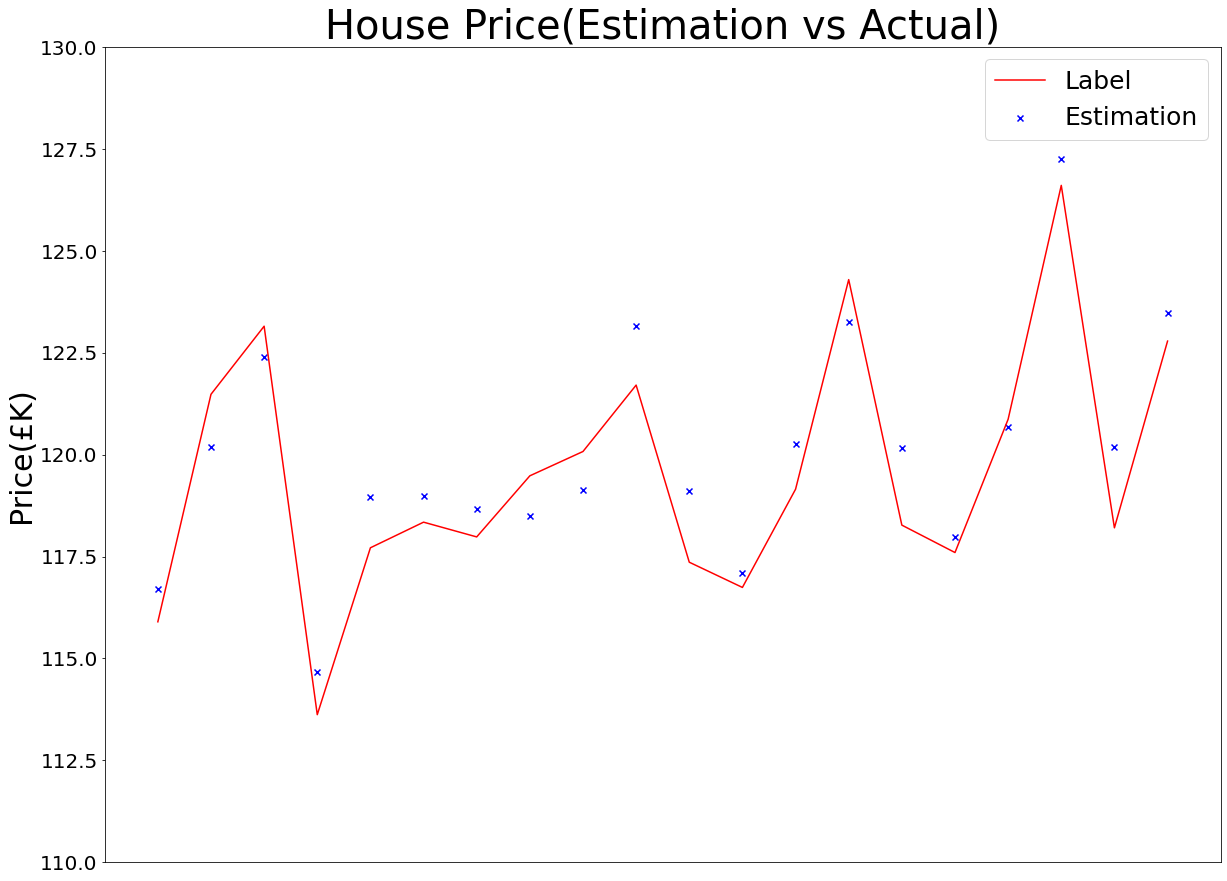

In [171]:


X = []
for i in range(r):
        X.append(i)
Y = Y_test["SalePriceLog"]*10
Y_hat = Y_test["SalePricePred"]*10
plot_h_vs_y(X, Y_hat[:r], Y[:r] )

In [172]:
print("--- %s minutes ---" % round((time.time() - start_time)/60,0))

--- 18.0 minutes ---
